In [26]:
import sqlite3
import pandas as pd

infant_csv = 'data/3_Mortality rate, infant (per 1,000 live births).csv'
skilled_csv = 'data/3_Births attended by skilled health staff (% of total).csv'
metadata = 'data/metadata.csv'

def clean_wdi(df):
    id_vars = ['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code']
    df = df.dropna(how='all', axis=1)  # Drop all-NaN columns
    value_vars = [col for col in df.columns if col.isdigit()]  # Years only
    df = df.melt(id_vars=id_vars, value_vars=value_vars, var_name='Year', value_name='Value')
    df = df.drop(columns=['Indicator Name', 'Indicator Code'])
    df['Year'] = df['Year'].astype(int)
    df['Value'] = pd.to_numeric(df['Value'], errors='coerce')
    return df

infant_mortality = clean_wdi(pd.read_csv(infant_csv, skiprows=4))
skilled_births = clean_wdi(pd.read_csv(skilled_csv, skiprows=4))
metadata = pd.read_csv(metadata, skiprows=4)

conn = sqlite3.connect(':memory:')
cursor = conn.cursor()
print("Database connected.")

infant_mortality.to_sql("infant_mortality", conn, if_exists="replace", index=False)
skilled_births.to_sql("skilled_births", conn, if_exists="replace", index=False)
metadata.to_sql("metadata", conn, if_exists="replace", index=False)

Database connected.


261

### Calculate Average Change in Infant Mortality and Skilled Births (2000–2019)

In [27]:
query_im_change = """
SELECT AVG(change) AS avg_infant_mortality_change
FROM (
    SELECT "Country Name", 
           MAX(Year) - MIN(Year) AS duration,
           MAX(Value) - MIN(Value) AS change
    FROM infant_mortality
    WHERE Year BETWEEN 2000 AND 2019
    GROUP BY "Country Name"
    HAVING COUNT(*) >= 2
)
"""

display(pd.read_sql(query_im_change, conn))

,avg_infant_mortality_change
0,20.377153


In [28]:
query_sb_change = """
SELECT AVG(change) AS avg_skilled_births_change
FROM (
    SELECT "Country Name", 
           MAX(Year) - MIN(Year) AS duration,
           MAX(Value) - MIN(Value) AS change
    FROM skilled_births
    WHERE Year BETWEEN 2000 AND 2019
    GROUP BY "Country Name"
    HAVING COUNT(*) >= 2
)
"""

display(pd.read_sql(query_sb_change, conn))

,avg_skilled_births_change
0,13.947243


### Create a Summary Table of Changes in Infant Mortality and Skilled Births for each Country (2000–2019)

In [29]:
query2 = """
DROP TABLE IF EXISTS health_change_summary;
CREATE TABLE health_change_summary AS
SELECT 
    im."Country Name",
    im."Country Code",
    meta.AFW AS code,
    meta."Unnamed: 1" AS region,
    MAX(im.Value) - MIN(im.Value) AS infant_mortality_change,
    MAX(sb.Value) - MIN(sb.Value) AS skilled_births_change
FROM 
    infant_mortality im
JOIN 
    skilled_births sb
    ON im."Country Code" = sb."Country Code" AND im.Year = sb.Year
LEFT JOIN 
    metadata meta
    ON im."Country Code" = meta.AFW
WHERE 
    im.Year BETWEEN 2000 AND 2019
    AND im.Value IS NOT NULL
    AND sb.Value IS NOT NULL
GROUP BY 
    im."Country Name", im."Country Code", meta.AFW, meta."Unnamed: 1"
HAVING 
    infant_mortality_change IS NOT NULL AND skilled_births_change IS NOT NULL;
"""
cursor.executescript(query2)
conn.commit()

df_health_change = pd.read_sql("SELECT * FROM health_change_summary", conn)
print(df_health_change.head())

                  Country Name Country Code  code                      region  \
0                  Afghanistan          AFG  None                        None   
1  Africa Eastern and Southern          AFE  None                        None   
2   Africa Western and Central          AFW  None                        None   
3                      Albania          ALB   ALB       Europe & Central Asia   
4                      Algeria          DZA   DZA  Middle East & North Africa   

   infant_mortality_change  skilled_births_change  
0                51.500000              46.400000  
1                43.012665              27.368288  
2                33.438869              17.058282  
3                10.100000               1.800000  
4                14.000000               6.800000  


### Changes and Regional Trends in Infant Mortality and Skilled Births (2000–2019)

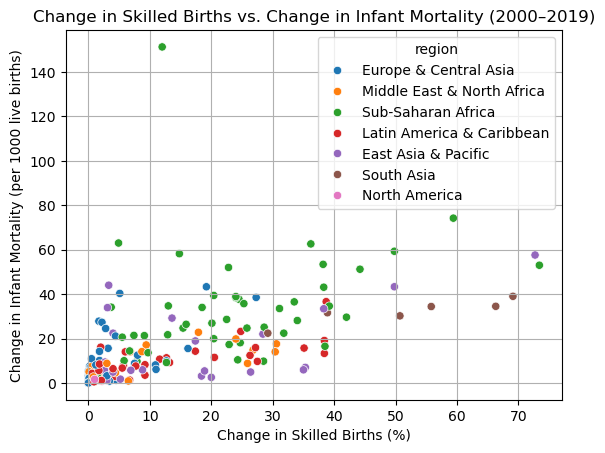

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(data=df_health_change, x='skilled_births_change', y='infant_mortality_change', hue='region')
plt.title('Change in Skilled Births vs. Change in Infant Mortality (2000–2019)')
plt.xlabel('Change in Skilled Births (%)')
plt.ylabel('Change in Infant Mortality (per 1000 live births)')
plt.grid(True)
plt.savefig('figures/change_skilled_births_vs_infant_mortality.png')
plt.show()

In [31]:
import plotly.express as px
import plotly.io as pio

metadata_sub = metadata[['AFW', 'Unnamed: 1']].copy()
metadata_sub = metadata_sub.rename(columns={'AFW': 'Country Code', 'Unnamed: 1': 'region'})

infant_mortality = infant_mortality.drop(columns=['region'], errors='ignore')
skilled_births = skilled_births.drop(columns=['region'], errors='ignore')

infant_mortality = infant_mortality.merge(
    metadata_sub,
    on='Country Code',
    how='left'
)

skilled_births = skilled_births.merge(
    metadata_sub,
    on='Country Code',
    how='left'
)

df_yearly = infant_mortality.merge(
    skilled_births[['Country Code', 'Year', 'Value', 'region']],
    on=['Country Code', 'Year', 'region'],
    suffixes=('_infant', '_skilled')
)

df_yearly = df_yearly.rename(columns={'Value_infant': 'Infant_Mortality', 'Value_skilled': 'Skilled_Births'})

df_yearly = df_yearly[(df_yearly['Year'] >= 2000) & (df_yearly['Year'] <= 2019)]

df_region = df_yearly.groupby(['region', 'Year']).agg({
    'Infant_Mortality': 'mean',
    'Skilled_Births': 'mean'
}).reset_index()

fig_im_region = px.line(
    df_region,
    x='Year',
    y='Infant_Mortality',
    color='region',
    title='Average Infant Mortality Rate Over Time by Region (2000–2019)',
    labels={'Infant_Mortality': 'Infant Mortality (per 1,000 live births)', 'region': 'Region'}
)
fig_im_region.show()
fig_im_region.write_image("figures/average_infant_mortality_by_region.png")

fig_sb_region = px.line(
    df_region,
    x='Year',
    y='Skilled_Births',
    color='region',
    title='Average Skilled Births Rate Over Time by Region (2000–2019)',
    labels={'Skilled_Births': 'Skilled Births (%)', 'region': 'Region'}
)
fig_sb_region.show()
fig_sb_region.write_image("figures/average_skilled_births_by_region.png")